This is a partial reproduction of [How Strongly do Dictionary Learning Features Influence Model Behavior?](https://transformer-circuits.pub/2024/april-update/index.html#ablation-exps) by Jack Lindsey, on GPT2-small.

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from teren import utils as teren_utils
from teren.typing import *

device = teren_utils.get_device_str()
print(f"{device=}")

device='cuda'


### load the transformer model

In [2]:
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


### set experiment parameters

In [3]:
# each layer is kind of independent experiment, but we save a lot of time by
# collecting dataset examples and residual stream activation for many layers at once

LAYERS = list(range(model.cfg.n_layers))
# LAYERS = 0, 5, 10

# pre-trained SAE model availavle in SAELens
SAE_RELEASE = "gpt2-small-res-jb"
LAYER_TO_SAE_ID = lambda layer: f"blocks.{layer}.hook_resid_pre"

# HF text  dataset
DATASET_PATH = "NeelNanda/c4-10k"
DATASET_SPLIT = "train[:5%]"

# how long each tokenized prompt should be
CONTEXT_SIZE = 32

# how many tokens can be forwarded through the transformer at once
# tune to your VRAM, 12_800 works well with 16GB
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // CONTEXT_SIZE
print(f"{INFERENCE_BATCH_SIZE=}")

# what is the minimum activation for a feature to be considered active
MIN_FEATURE_ACTIVATION = 0.0
# minimum number of tokenized prompts that should have a feature active
# for the feature to be included in the experiment
MIN_EXAMPLES_PER_FEATURE = 30
# ids of feature to consider in the experiment
# we can't consider all the features, because of compute & memory constraints
CONSIDER_FIDS = [FeatureId(i) for i in range(30)]

# for Lindsey's note replication this should be always 1
# but this is useful for debugging
DEBUG_SCALE = 1.0

INFERENCE_BATCH_SIZE=400


### load SAE models, one for each layer

In [4]:
from sae_lens import SAE

sae_by_layer = {
    # ignore other things it returns
    layer: SAE.from_pretrained(
        release=SAE_RELEASE, sae_id=LAYER_TO_SAE_ID(layer), device=device
    )[0]
    for layer in LAYERS
}

In [5]:
all_input_ids = teren_utils.load_and_tokenize_dataset(
    path=DATASET_PATH,
    split=DATASET_SPLIT,
    column_name="text",
    tokenizer=model.tokenizer,  # type: ignore
    max_length=CONTEXT_SIZE,
)
print(f"all_input_ids (tokenized dataset) shape: {tuple(all_input_ids.shape)}")

all_input_ids (tokenized dataset) shape: (7633, 32)


### collect examples, residual stream activations and clean loss

For each layer:
 - find features that were active in at least `MIN_EXAMPLES_PER_FEATURE` tokenized prompts
 - collect these prompts for each feature
 - collect residual stream activation on these prompts
 - compute the loss on these prompts

We're doing it all at once to reduce the number of model inference runs.  
The data is stored in CPU RAM, not VRAM.

In [6]:
from teren.sae_examples import (
    get_sae_feature_examples_by_layer_and_resid_mean_by_layer,
    SAEFeatureExamples,
)

sae_feature_examples_by_layer, resid_mean_by_layer = (
    get_sae_feature_examples_by_layer_and_resid_mean_by_layer(
        input_ids=all_input_ids,
        model=model,
        sae_by_layer=sae_by_layer,
        fids=CONSIDER_FIDS,
        n_examples=MIN_EXAMPLES_PER_FEATURE,
        batch_size=INFERENCE_BATCH_SIZE,
        min_activation=MIN_FEATURE_ACTIVATION,
    )
)

# display high-level summary of the data
for layer, sae_feature_examples in sae_feature_examples_by_layer.items():
    print(f"Layer: {layer}")
    active_feature_ids = sae_feature_examples.fids
    print(f"Number of selected features: {len(active_feature_ids)}")
    print(f"Active feature ids: {active_feature_ids}")
    print()

Layer: 0
Number of selected features: 18
Active feature ids: [FeatureId(int=0), FeatureId(int=2), FeatureId(int=3), FeatureId(int=4), FeatureId(int=5), FeatureId(int=7), FeatureId(int=9), FeatureId(int=11), FeatureId(int=13), FeatureId(int=15), FeatureId(int=17), FeatureId(int=18), FeatureId(int=19), FeatureId(int=20), FeatureId(int=24), FeatureId(int=25), FeatureId(int=28), FeatureId(int=29)]

Layer: 1
Number of selected features: 8
Active feature ids: [FeatureId(int=1), FeatureId(int=2), FeatureId(int=6), FeatureId(int=11), FeatureId(int=12), FeatureId(int=25), FeatureId(int=26), FeatureId(int=27)]

Layer: 2
Number of selected features: 14
Active feature ids: [FeatureId(int=0), FeatureId(int=1), FeatureId(int=2), FeatureId(int=4), FeatureId(int=9), FeatureId(int=10), FeatureId(int=12), FeatureId(int=13), FeatureId(int=15), FeatureId(int=20), FeatureId(int=23), FeatureId(int=26), FeatureId(int=28), FeatureId(int=29)]

Layer: 3
Number of selected features: 15
Active feature ids: [Featu

In [7]:
def print_examples_shapes(layer: int):
    print(f"Layer: {layer}")
    examples_by_feature = sae_feature_examples_by_layer[layer]
    print(
        f"input_ids shape: {tuple(examples_by_feature.input_ids.shape)} (n_features, n_examples, context_size)"
    )
    print(
        f"resid_acts shape: {tuple(examples_by_feature.resid_acts.shape)} (n_features, n_examples, context_size, d_model)"
    )
    print(
        f"clean_loss shape: {tuple(examples_by_feature.clean_loss.shape)} (n_features, n_examples, context_size - 1)"
    )


print_examples_shapes(LAYERS[0])

Layer: 0
input_ids shape: (18, 30, 32) (n_features, n_examples, context_size)
resid_acts shape: (18, 30, 32, 768) (n_features, n_examples, context_size, d_model)
clean_loss shape: (18, 30, 31) (n_features, n_examples, context_size - 1)


### check if we can reconstruct the loss from saved residual stream activations
If we run the transformer blocks `n, n+1, ..., N-1` starting from activation saved at layer `n`, will we get the same loss as when running the full model?

In [8]:
def test_clean_loss_correct():
    for layer, examples_by_feature in sae_feature_examples_by_layer.items():
        sae = sae_by_layer[layer]
        loss_by_feature = teren_utils.compute_loss(
            model=model,
            input_ids=examples_by_feature.input_ids,
            resid_acts=examples_by_feature.resid_acts,
            start_at_layer=sae.cfg.hook_layer,
            batch_size=INFERENCE_BATCH_SIZE,
        )
        assert torch.allclose(
            examples_by_feature.clean_loss, loss_by_feature, rtol=1e-3, atol=1e-5
        )


test_clean_loss_correct()

### main part: apply perturbations

In [9]:
from teren.perturbations import (
    Perturbation,
    NaiveRandomPerturbation,
    DampenResidActsPerturbation,
    TowardSAEReconPerturbation,
    DampenSEAFeaturePerturbation,
    AmplifySEAFeaturePerturbation,
)

Some perturbations need to be initialized with arguments that depend on specific SAE/layer or even a specific feature id. Some of them don't, but we assume all do and just keep a bunch redundant references for them, to simplify the API.

In [10]:
def get_pert_by_fid_by_name(
    fids: list[FeatureId], sae: SAE, resid_mean: Float[torch.Tensor, "seq model"]
) -> Mapping[str, Mapping[FeatureId, Perturbation]]:
    """For every perturbation name, return a dictionary of perturbations by feature id

    Perturbation names correspond to a plot labels. Not every perturbation depends on feature id,
    in which case every feature id is mapped to the same perturbation object.
    """
    return {
        # dampen_resid_acts_perturbation w/o scaling
        # results in setting residual stream to 0
        # used as reference, to get a relative scale for plots
        # take the mean along feature and batch dimensions, keep sequence and d_model
        "ablate_resid": DampenResidActsPerturbation.get_pert_by_fid(fids, resid_mean),
        # ablate single SAE feature
        # DampenSEAFeaturePerturbation w/o scaling
        # results in setting a single feature to 0
        # every other perturbation is normalized to match the norm of this one
        "ablate_sae_feature": DampenSEAFeaturePerturbation.get_pert_by_fid(fids, sae),
        # double a single SAE feature
        # AmplifySEAFeaturePerturbation, norm is equal to feature ablation
        "double_sae_feature": AmplifySEAFeaturePerturbation.get_pert_by_fid(fids, sae),
        # move residual stream activations towards SAE reconstruction
        "toward_sae_recon": TowardSAEReconPerturbation.get_pert_by_fid(fids, sae),
        # move in a random direction
        "naive_random": NaiveRandomPerturbation.get_pert_by_fid(fids),
    }


def get_pert_by_fid_by_name_by_layer(
    sae_feature_examples_by_layer: Mapping[int, SAEFeatureExamples],
    sae_by_layer: Mapping[int, SAE],
    resid_mean_by_layer: Mapping[int, Float[torch.Tensor, "seq model"]],
) -> Mapping[int, Mapping[str, Mapping[FeatureId, Perturbation]]]:
    """Do get_pert_by_fid_by_name() for all layers"""
    pert_by_fid_by_name_by_layer = {}
    for layer, sae_feature_examples in sae_feature_examples_by_layer.items():
        sae = sae_by_layer[layer]
        resid_mean = resid_mean_by_layer[layer]
        fids = sae_feature_examples.fids
        pert_by_fid_by_name_by_layer[layer] = get_pert_by_fid_by_name(
            fids, sae, resid_mean
        )
    return pert_by_fid_by_name_by_layer


pert_by_fid_by_name_by_layer = get_pert_by_fid_by_name_by_layer(
    sae_feature_examples_by_layer, sae_by_layer, resid_mean_by_layer
)

In [11]:
def get_pert_vec_and_pert_norm(
    sae_feature_examples: SAEFeatureExamples,
    pert_by_fid: Mapping[FeatureId, Perturbation],
) -> tuple[
    Float[torch.Tensor, "feature batch seq model"],
    Float[torch.Tensor, "feature batch seq"],
]:
    pert_vec = DEBUG_SCALE * sae_feature_examples.compute_pert_vectors(pert_by_fid)
    pert_norm = pert_vec.norm(p=2, dim=-1, keepdim=True)
    assert pert_norm.isfinite().all()
    return pert_vec, pert_norm


def get_pert_norm_and_loss(
    layer: int,
    sae_feature_examples: SAEFeatureExamples,
    pert_by_fid: Mapping[FeatureId, Perturbation],
):
    """Apply perturbation with no scaling, return perturbation norm and loss"""
    pert_vec, pert_norm = get_pert_vec_and_pert_norm(sae_feature_examples, pert_by_fid)
    pert_resid_acts = sae_feature_examples.resid_acts + pert_vec
    loss_by_feature = teren_utils.compute_loss(
        model=model,
        input_ids=sae_feature_examples.input_ids,
        resid_acts=pert_resid_acts,
        start_at_layer=layer,
        batch_size=INFERENCE_BATCH_SIZE,
    )
    return pert_norm, loss_by_feature


def get_pert_loss(
    layer: int,
    sae_feature_examples: SAEFeatureExamples,
    pert_by_fid: Mapping[FeatureId, Perturbation],
    # replace with scale: float for Stefan's experiments
    target_pert_norm: Float[torch.Tensor, "feature batch seq"],
):
    """Apply perturbation with target norm, return perturbation loss"""
    pert_vec, pert_norm = get_pert_vec_and_pert_norm(sae_feature_examples, pert_by_fid)
    # Feature doubling perturbation is 0 if feature wasn't active,
    # mask is used to avoid division by 0
    pert_scale = torch.ones_like(target_pert_norm)
    mask = pert_norm > 0
    pert_scale[mask] = target_pert_norm[mask] / pert_norm[mask]
    resid_acts = sae_feature_examples.resid_acts
    pert_resid_acts = resid_acts + pert_vec * pert_scale
    # TODO: for Stefan's repro have KL div option (and store logits, and maybe L2)
    return teren_utils.compute_loss(
        model=model,
        input_ids=sae_feature_examples.input_ids,
        resid_acts=pert_resid_acts,
        start_at_layer=layer,
        batch_size=INFERENCE_BATCH_SIZE,
    )


def compute_loss_by_pert(
    layer: int, examples_by_feature: SAEFeatureExamples, pert_by_feature_id_by_name
):
    """Compute losses for all perturbations for a single SAE"""
    target_pert_norm, ablate_sae_feature_loss = get_pert_norm_and_loss(
        layer, examples_by_feature, pert_by_feature_id_by_name["ablate_sae_feature"]
    )
    loss_by_pert = {"ablate_sae_feature": ablate_sae_feature_loss}

    for pert_name, pert_by_feature_id in pert_by_feature_id_by_name.items():
        if pert_name == "ablate_sae_feature":
            continue
        loss_by_pert[pert_name] = get_pert_loss(
            layer, examples_by_feature, pert_by_feature_id, target_pert_norm
        )
    return loss_by_pert


def compute_loss_by_pert_by_layer(
    sae_feature_examples_by_layer: Mapping[int, SAEFeatureExamples],
    pert_by_fid_by_name_by_layer: Mapping[
        int, Mapping[str, Mapping[FeatureId, Perturbation]]
    ],
):
    loss_by_pert_by_layer = {}
    for layer, sae_feature_examples in sae_feature_examples_by_layer.items():
        pert_by_fid_by_name = pert_by_fid_by_name_by_layer[layer]
        loss_by_pert_by_layer[layer] = compute_loss_by_pert(
            layer, sae_feature_examples, pert_by_fid_by_name
        )
    return loss_by_pert_by_layer


# losses for all perturbations for all layers
loss_by_pert_by_layer = compute_loss_by_pert_by_layer(
    sae_feature_examples_by_layer, pert_by_fid_by_name_by_layer
)
# check if loss is finite
for layer, loss_by_pert in loss_by_pert_by_layer.items():
    for pert_name, loss in loss_by_pert.items():
        assert (
            loss.isfinite().all()
        ), f"layer {layer}, {pert_name}: {loss.isfinite().sum().item()}/{loss.nelement()} loss elements finite"
# we're not plotting this one directly, it's only used for normalization
ablate_resid_loss_by_layer = {
    layer: loss_by_pert.pop("ablate_resid")
    for layer, loss_by_pert in loss_by_pert_by_layer.items()
}

### plot the results

In [12]:
import pandas as pd


def compute_plot_data(loss_by_pert, clean_loss, ablate_resid_loss, layer):
    loss_by_feature_by_pert = {}
    for pert_name, loss in loss_by_pert.items():
        # loss increase, relative to ablated residual stream
        # (n_features, batch, n_ctx-1)
        normalized_loss = (loss - clean_loss) / ablate_resid_loss

        # max variant
        # take the highest loss value for each prompt
        # (n_features, batch)
        normalized_loss_ctx_max = normalized_loss.max(dim=-1).values
        # mean over batch, resulting shape is (n_features,)
        loss_by_feature = normalized_loss_ctx_max.mean(-1)

        # # mean variant
        # # take the mean loss value for each prompt
        # normalized_loss_ctx_mean = normalized_loss.mean(dim=-1)
        # # mean over batch, resulting shape is (n_features,)
        # loss_by_feature = normalized_loss_ctx_mean.mean(-1)

        loss_by_feature_by_pert[pert_name] = loss_by_feature

    df_dicts = []
    for pert_name, loss_by_feature in loss_by_feature_by_pert.items():
        # here mean and std are computed over features
        df_dicts.append(
            {
                "name": pert_name,
                "loss": loss_by_feature.mean().item(),
                "std_loss": loss_by_feature.std().item(),
                "layer": layer,
            }
        )
    return df_dicts


df_dicts = []
for layer, sae_feature_examples in sae_feature_examples_by_layer.items():
    loss_by_pert = loss_by_pert_by_layer[layer]
    ablate_resid_loss = ablate_resid_loss_by_layer[layer]
    df_dicts += compute_plot_data(
        loss_by_pert,
        sae_feature_examples.clean_loss,
        ablate_resid_loss,
        layer,
    )
df = pd.DataFrame(df_dicts)
df[:20:2]

,name,loss,std_loss,layer
0,ablate_sae_feature,0.119786,0.193174,0
2,toward_sae_recon,0.067944,0.127292,0
4,ablate_sae_feature,0.208556,0.233273,1
6,toward_sae_recon,0.097582,0.136643,1
8,ablate_sae_feature,0.093157,0.111072,2
10,toward_sae_recon,1.262166,3.992751,2
12,ablate_sae_feature,0.197983,0.333589,3
14,toward_sae_recon,11.305099,39.098347,3
16,ablate_sae_feature,0.037080,0.045710,4
18,toward_sae_recon,0.059384,0.094706,4


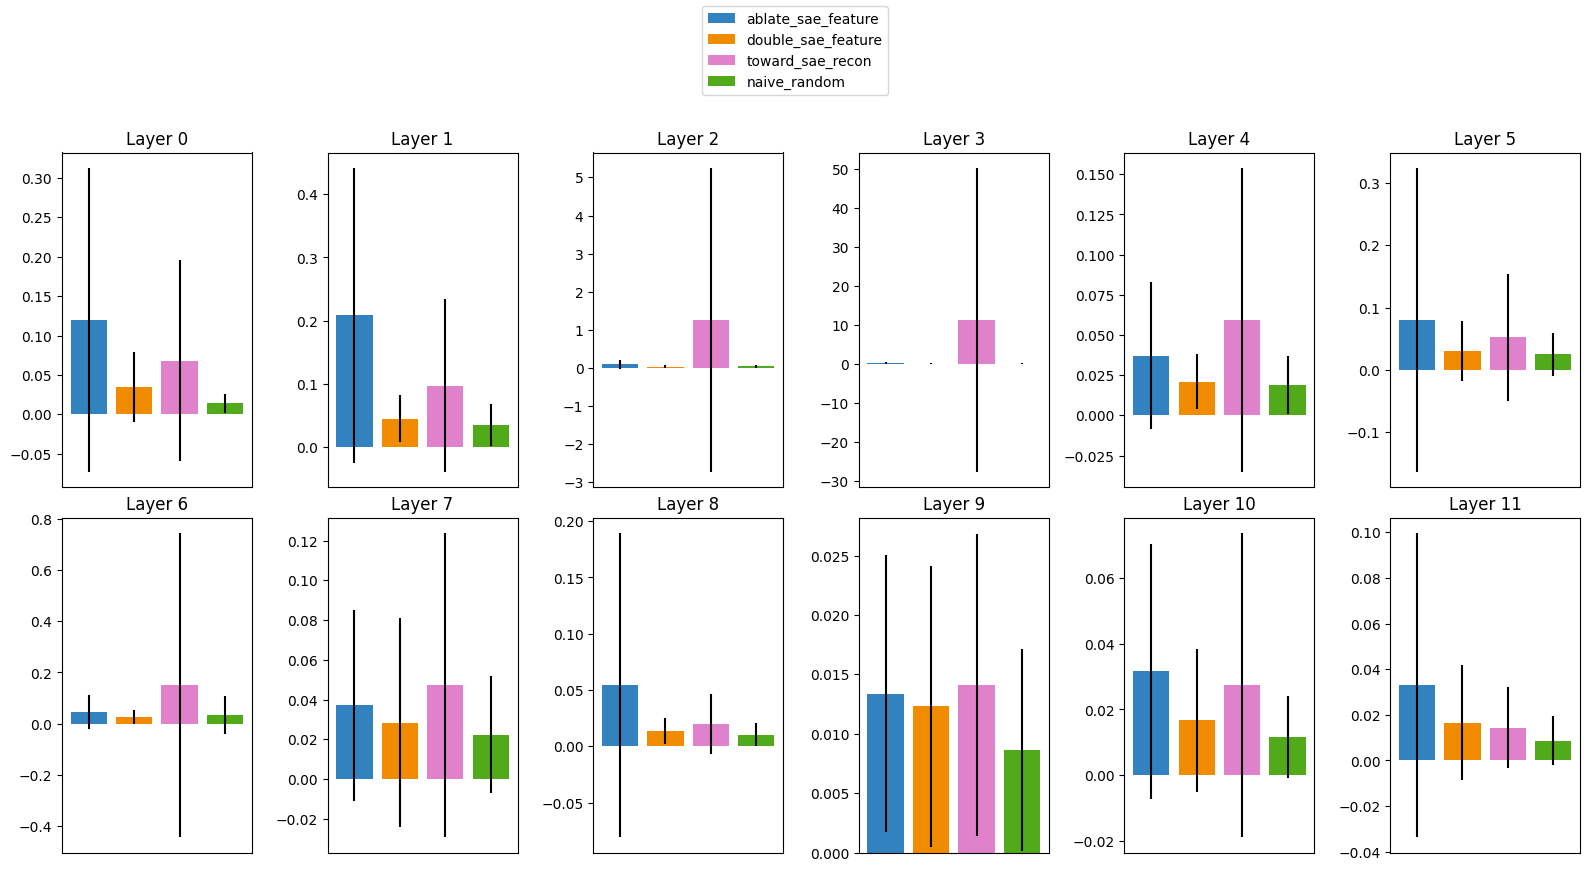

In [13]:
import matplotlib.pyplot as plt
import math

color_map = {
    "naive_random": "#51aa19",
    "double_sae_feature": "#f18b00",
    "ablate_sae_feature": "#3282c0",
    "toward_sae_recon": "#df82cb",
}

# Initialize the plot
layers = df["layer"].unique()
n_layers = len(layers)
cols = 6
rows = max(2, math.ceil(n_layers / cols))
fig, axes = plt.subplots(rows, cols, figsize=(16, 10), sharey=False)

# Plot each layer
for i, layer in enumerate(layers):
    col = i % cols
    row = i // cols
    ax = axes[row][col]
    layer_df = df[df["layer"] == layer]
    color = [color_map[name] for name in layer_df["name"]]
    ax.bar(
        layer_df["name"],
        layer_df["loss"],
        yerr=layer_df["std_loss"],
        label=layer_df["name"],
        color=color,
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("")
    ax.set_xticks([])  # Remove x-ticks

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)  # Adjusted to make room for the legend
plt.show()